# Text Classification using Machine Learning algorithms

##Importing necessary libraries to build model

In [ ]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import tweepy
from textblob import TextBlob
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import requests
import nltk # for text manipulation
from nltk.stem.porter import *
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sid
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

##Extracting dataset and Reviewing Our Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df=pd.read_csv("/content/drive/My Drive/covid19_tweets.csv")
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Republican #Capitalist; Sports lover - #BBN #Cincinnati #Reds #Bengals #Trump2020,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs #Resist,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that were always around me… https://t.co/Z0pOAlFXcW,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,"🖊️Official Twitter handle of Department of Information and Public Relations, Govt of Jammu & Kashmir",2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 \n@kansalrohit69 @DrSyedSehrish @airnewsalerts @ANI… https://t.co/MN0EEcsJHh,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


#Data Preprocessing

**A) Removing @user**

In [ ]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt
# create new column with removed @user
df['clean_text'] = np.vectorize(remove_pattern)(df['text'], '@[\w]*')
df.head(2)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0"
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,Hey PR and - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu


##REMOVED HTTP AND URLS FROM TWEET

In [ ]:
import re
df['clean_text'] = df['clean_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df.head(3)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that…"
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,Hey PR and - wouldn't it have made more sense to have the players pay their respects to the A…
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Republican #Capitalist; Sports lover - #BBN #Cincinnati #Reds #Bengals #Trump2020,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3,['COVID19'],Twitter for Android,False,Trump never once claimed #COVID19 was a hoax. We all claim that this effort to…


##**B) Removing Punctuations, Numbers, and Special Characters**

In [ ]:
# remove special characters, numbers, punctuations
df['clean_text'] = df['clean_text'].str.replace('[^a-zA-Z#]+',' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
df.head(5)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,If I smelled the scent of hand sanitizers today on someone in the past I would think they were so intoxicated that
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,Hey PR and wouldn t it have made more sense to have the players pay their respects to the A
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Republican #Capitalist; Sports lover - #BBN #Cincinnati #Reds #Bengals #Trump2020,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3,['COVID19'],Twitter for Android,False,Trump never once claimed #COVID was a hoax We all claim that this effort to
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs #Resist,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that were always around me… https://t.co/Z0pOAlFXcW,['COVID19'],Twitter for iPhone,False,The one gift #COVID has give me is an appreciation for the simple things that were always around me
4,DIPR-J&K,Jammu and Kashmir,"🖊️Official Twitter handle of Department of Information and Public Relations, Govt of Jammu & Kashmir",2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 \n@kansalrohit69 @DrSyedSehrish @airnewsalerts @ANI… https://t.co/MN0EEcsJHh,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,July Media Bulletin on Novel #CoronaVirusUpdates #COVID


##**C) Removing Short Words**

In [ ]:
# remove short words
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
df.head(2)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,smelled the scent hand sanitizers today someone the past would think they were intoxicated that
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,Hey and wouldn have made more sense have the players pay their respects the


##**D) Tokenization**

In [ ]:
# create new variable tokenized tweet 
tokenized_tweet = df['clean_text'].apply(lambda x: x.split())
df.head(2)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,smelled the scent hand sanitizers today someone the past would think they were intoxicated that
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,Hey and wouldn have made more sense have the players pay their respects the


##**E) Stemming**

In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
df.head(2)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,smelled the scent hand sanitizers today someone the past would think they were intoxicated that
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,Hey and wouldn have made more sense have the players pay their respects the


In [ ]:
# join tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
# change df['clean_text'] to tokenized_tweet

In [ ]:
df['clean_text']  = tokenized_tweet
df.head(2)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,smell the scent hand sanit today someon the past would think they were intox that
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,hey and wouldn have made more sens have the player pay their respect the


#**Extracting Features from Cleaned Tweets**
###Removing Stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [ ]:
df['clean_text'].apply(lambda x: [item for item in x if item not in stop])

0                           [e, l, l,  , h, e,  , c, e, n,  , h, n,  , n,  ,  , e, n,  , h, e,  , p,  , w, u, l,  , h, n, k,  , h, e,  , w, e, r, e,  , n, x,  , h]
1                  [h, e,  , n,  , w, u, l, n,  , h, v, e,  , e,  , r, e,  , e, n,  , h, v, e,  , h, e,  , p, l, e, r,  , p,  , h, e, r,  , r, e, p, e, c,  , h, e]
2                                             [r, u, p,  , n, e, v, e, r,  , n, c,  , c, l,  , #, c, v,  , w,  , h, x,  , l, l,  , c, l,  , h,  , h,  , e, f, f, r]
3         [h, e,  , n, e,  , g, f,  , #, c, v,  , h,  , g, v, e,  , p, p, r, e, c,  , f, r,  , h, e,  , p, l,  , h, n, g,  , h,  , w, e, r, e,  , l, w,  , r, u, n]
4                                                                     [j, u, l,  , e,  , b, u, l, l, e, n,  , n, v, e, l,  , #, c, r, n, v, r, u, u, p,  , #, c, v]
                                                                                    ...                                                                            
179103          

##Check and calculate sentiment of tweets

In [ ]:
#creates a function that determines subjectivity and polarity from the textblob package
def getTextSubjectivity(clean_text):
    return TextBlob(clean_text).sentiment.subjectivity
def getTextPolarity(clean_text):
    return TextBlob(clean_text).sentiment.polarity
#applies these functions to the dataframe
df['Subjectivity'] = df['clean_text'].apply(getTextSubjectivity)
df['Polarity'] = df['clean_text'].apply(getTextPolarity)
#builds a function to calculate and categorize each tweet as Negative, Neutral, and Positive
def getTextAnalysis(a):
    if a < 0:
        return "Negative"
    elif a == 0:
        return "Neutral"
    else:
        return "Positive"
#creates another column called Score and applies the function to the dataframe
df['Score'] = df['Polarity'].apply(getTextAnalysis)

In [ ]:
new_df=df[['clean_text','Score']]

In [ ]:
new_df.shape

(179108, 2)

In [ ]:
new_df.head(1)

,clean_text,Score
0,smell the scent hand sanit today someon the past would think they were intox that,Negative


In [ ]:
data=new_df.head(20000)

# SVM (Support Vector Machine)

In [ ]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(data,test_size = 0.3,random_state=0,stratify = data.Score.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (14000, 2)
valid shape :  (6000, 2)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.clean_text.values)
X_valid = vectorizer.transform(valid.clean_text.values)

y_train = train.Score.values
y_valid = valid.Score.values

print("X_train.shape : ", X_train.shape)
print("X_valid.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (14000, 15056)
X_valid.shape :  (6000, 15056)
y_train.shape :  (14000,)
y_valid.shape :  (6000,)


In [ ]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_valid)
svc_accuracy = accuracy_score(y_valid,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Validation accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_valid))

Training accuracy Score    :  0.958
Validation accuracy Score :  0.8391666666666666
              precision    recall  f1-score   support

    Negative       0.48      0.89      0.62       470
     Neutral       1.00      0.79      0.88      3857
    Positive       0.76      0.94      0.84      1673

    accuracy                           0.84      6000
   macro avg       0.74      0.87      0.78      6000
weighted avg       0.89      0.84      0.85      6000



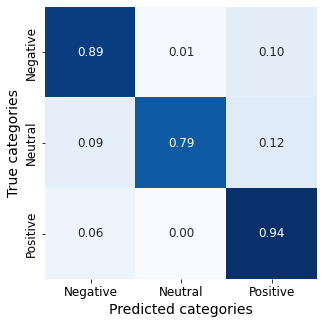

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(svc_prediction,y_valid)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
sents=['Negative','Neutral','Positive']
confusion_df = pd.DataFrame(matrix_proportions, index=sents,columns=sents)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='Blues',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

## BPNN (Back Propagation Neural Network)

In [ ]:
# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

# split data into train and test set
from sklearn.model_selection import train_test_split

In [ ]:
train,valid = train_test_split(data,test_size = 0.2,random_state=0,stratify = data.Score.values)
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

x_train = vectorizer.fit_transform(train.clean_text.values)
x_valid = vectorizer.transform(valid.clean_text.values)

y_train = train.Score.values
y_valid = valid.Score.values

In [ ]:
model = Sequential()

col=x_train.shape[1]

model.add(Dense(1000, activation='relu', input_shape =(col,)))
model.add(Dense(1000, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=1000)
mlp.fit(x_train, y_train)
predictions = mlp.predict(x_valid)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(predictions,y_valid))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              16189000  
                                                                 
 dense_1 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_2 (Dense)             (None, 3)                 3003      
                                                                 
Total params: 17,193,003
Trainable params: 17,193,003
Non-trainable params: 0
_________________________________________________________________
None
              precision    recall  f1-score   support

    Negative       0.66      0.72      0.68       534
     Neutral       0.88      0.86      0.87      2098
    Positive       0.81      0.82      0.82      1368

    accuracy                           0.82      4000
   macro avg       0.78      0.

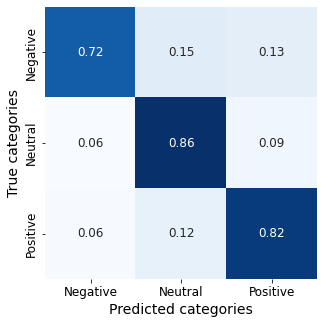

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(predictions,y_valid)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
sents=['Negative','Neutral','Positive']
confusion_df = pd.DataFrame(matrix_proportions, index=sents,columns=sents)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='Blues',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

## Logistic Regression

train shape :  (125375, 2)
valid shape :  (53733, 2)
X_train.shape :  (125375, 55738)
X_valid.shape :  (53733, 55738)
y_train.shape :  (125375,)
y_valid.shape :  (53733,)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Training accuracy Score    :  0.9459621136590229
Validation accuracy Score :  0.9273816835092029
              precision    recall  f1-score   support

    Negative       0.82      0.91      0.86      6871
     Neutral       0.99      0.92      0.95     29777
    Positive       0.88      0.96      0.92     17085

    accuracy                           0.93     53733
   macro avg       0.90      0.93      0.91     53733
weighted avg       0.93      0.93      0.93     53733



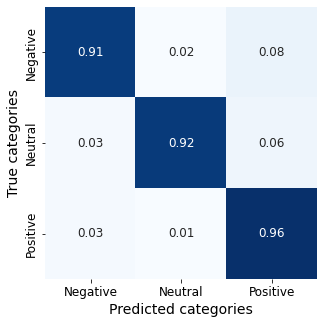

In [ ]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(new_df,test_size = 0.3,random_state=0,stratify = new_df.Score.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.clean_text.values)
X_valid = vectorizer.transform(valid.clean_text.values)

y_train = train.Score.values
y_valid = valid.Score.values

print("X_train.shape : ", X_train.shape)
print("X_valid.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(logreg_prediction,y_valid)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
sents=['Negative','Neutral','Positive']
confusion_df = pd.DataFrame(matrix_proportions, index=sents,columns=sents)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='Blues',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

## Random Forest Classifier

In [ ]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(data,test_size = 0.3,random_state=0,stratify = data.Score.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.clean_text.values)
X_valid = vectorizer.transform(valid.clean_text.values)

y_train = train.Score.values
y_valid = valid.Score.values

print("X_train.shape : ", X_train.shape)
print("X_valid.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Validation accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_valid))

train shape :  (14000, 2)
valid shape :  (6000, 2)
X_train.shape :  (14000, 15056)
X_valid.shape :  (6000, 15056)
y_train.shape :  (14000,)
y_valid.shape :  (6000,)
Training accuracy Score    :  0.9999285714285714
Validation accuracy Score :  0.9043333333333333
              precision    recall  f1-score   support

    Negative       0.72      0.90      0.80       693
     Neutral       0.99      0.89      0.94      3400
    Positive       0.86      0.93      0.89      1907

    accuracy                           0.90      6000
   macro avg       0.85      0.91      0.88      6000
weighted avg       0.92      0.90      0.91      6000



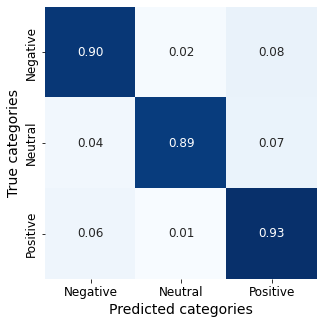

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(rf_prediction,y_valid)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
sents=['Negative','Neutral','Positive']
confusion_df = pd.DataFrame(matrix_proportions, index=sents,columns=sents)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='Blues',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#*Thank you! :)*